## Tiny NeRF (A PyTorch implementation)

So, this weekend, I was catching up on this _cool paper_ titled [*NeRF: Representing scenes as neural radiance fields for view synthesis*](https://arxiv.org/abs/2003.08934)!

The authors released a TensorFlow implementation [here](https://github.com/bmild/nerf). Deciding to delve deeper, I ported their code to PyTorch, cause why not!

> *DISCLAIMER*: This notebook (and repository) is work-in-progress. Although I have rigorously tested most modules in here (to faithfully replicate the original implementation), my implementation at places deviates from the authors'. Comments/criticism welcome!

> All functions that have a `#TESTED` under the docstring imply that they have been tested against their corresponding tensorflow impls.

In [ ]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [ ]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [ ]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [ ]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [ ]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [ ]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if i nclude_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [ ]:
#class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

IndentationError: unexpected indent (<ipython-input-7-1bb940c53d5c>, line 2)

## NeRF: Network architecture

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    self.block1 = torch.nn.Sequential(
                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),

                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),

                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),

                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU())

    self.block2 = torch.nn.Sequential(  torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU(),
                                        torch.nn.Linear(filter_size, filter_size),
                                        torch.nn.ReLU())

    self.layer1 = torch.nn.Sequential(torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size),
                                      torch.nn.ReLU())
    self.layer2 = torch.nn.Sequential(torch.nn.Linear(filter_size, 4))


  def forward(self, x):

    x = self.layer1(x)
    x = self.block1(x) + x
    x = self.block2(x) + x
    x = self.layer2(x)
    return x

  def get_features(self):
    self.features = self.layer1 + self.block1 + self.block2 + self.layer2
    return self.features

## Dataloading utils

In [ ]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [ ]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget --no-check-certificate http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2024-05-07 12:28:12--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-05-07 12:28:12--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M   699KB/s    in 18s     

2024-05-07 12:28:39 (686 KB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Determine device to run on (GPU vs CPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)
#images1 = images[:50]
#images2 = images[51:100]
#images1[:, height//2 + 10:, :, :] = 0
#images2[:, :height//2 - 10, :, :] = 0

#tform_cam2world = tform_cam2world[:100]
#tform_cam2world1 = tform_cam2world[:50]
#tform_cam2world2 = tform_cam2world[51:100]

#### Display the image used for testing

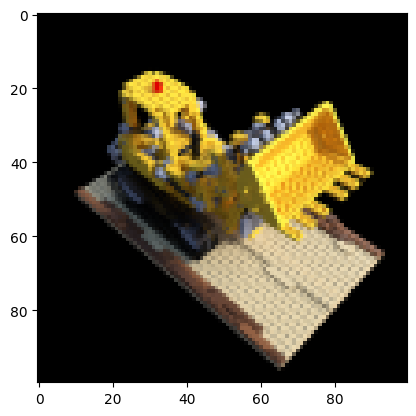

In [ ]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

(The cool part!)

In [ ]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf_front(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model_front(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [ ]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf_rear(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model_rear(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-4
num_iters = 1000

# Misc parameters
display_every = 25  # Number of iters after which stats are displayed


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.11416338384151459
Loss: 0.08977148681879044


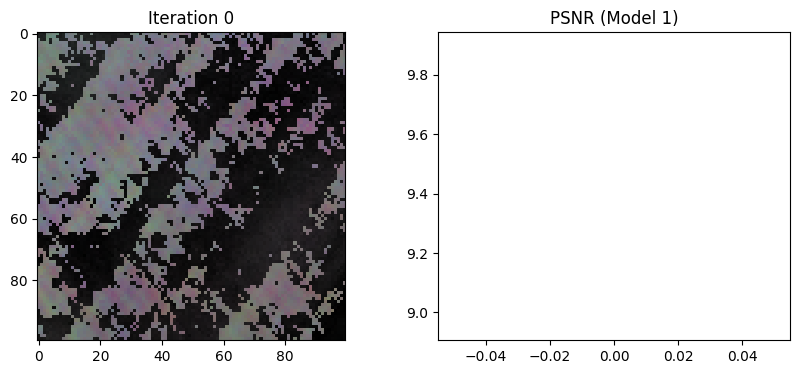

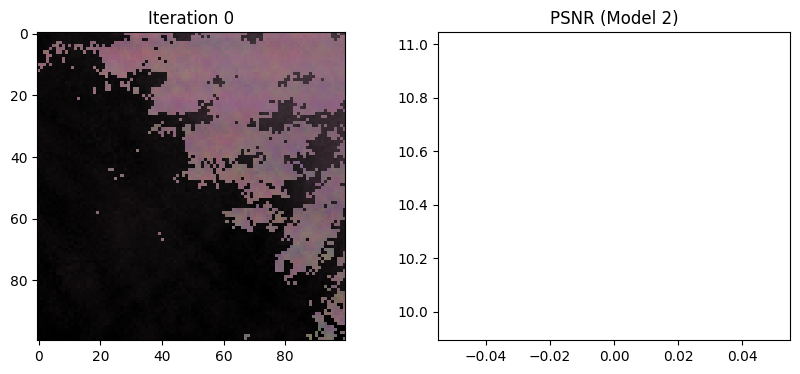

Loss: 0.13463838398456573
Loss: 0.1342654973268509


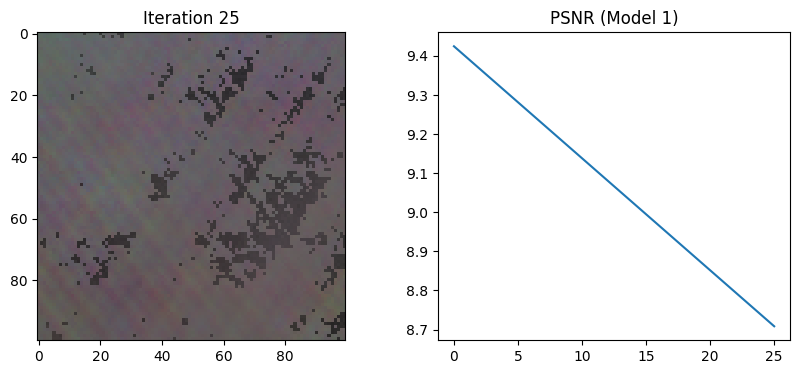

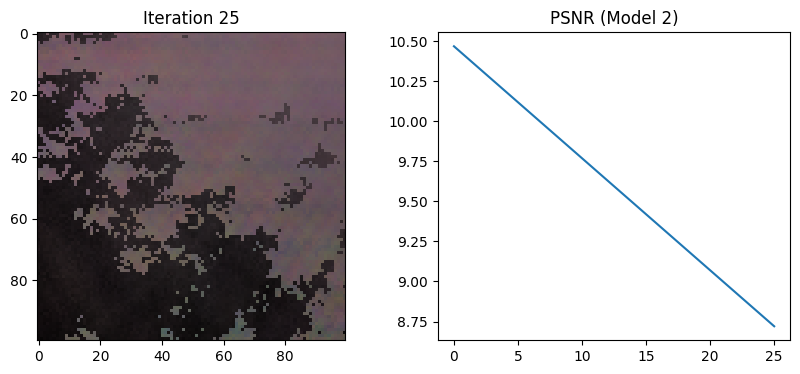

Loss: 0.05406792461872101
Loss: 0.05337632820010185


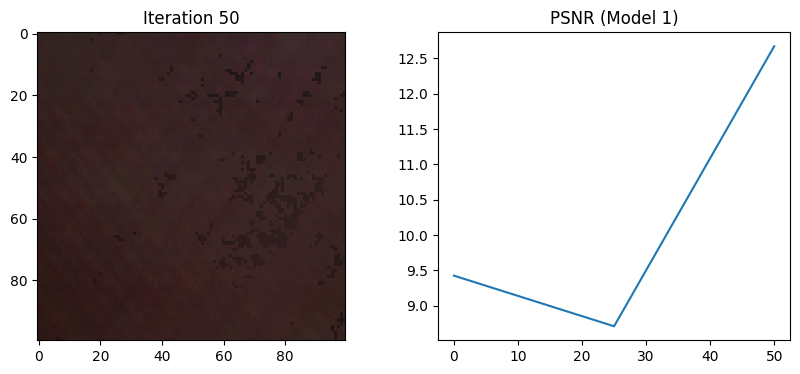

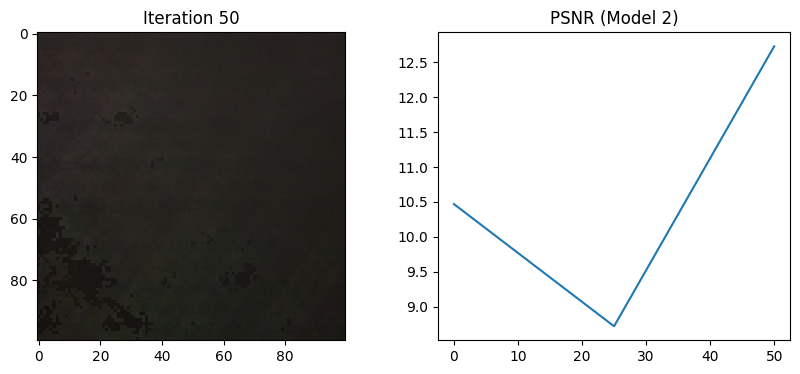

Loss: 0.05580117926001549
Loss: 0.05606395751237869


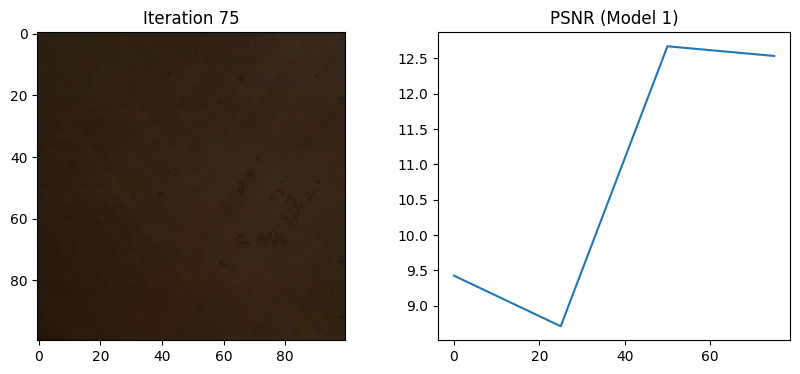

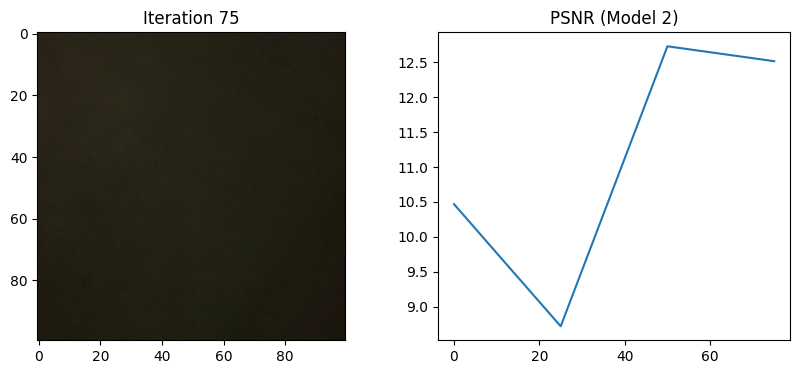

Loss: 0.07764028757810593
Loss: 0.07983729988336563


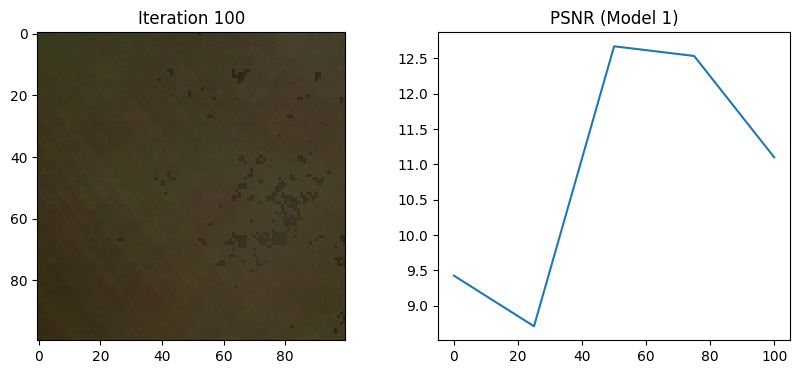

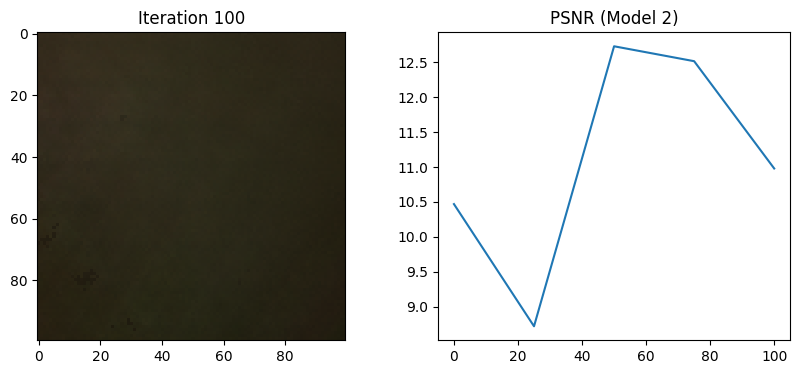

Loss: 0.10463004559278488
Loss: 0.10680162161588669


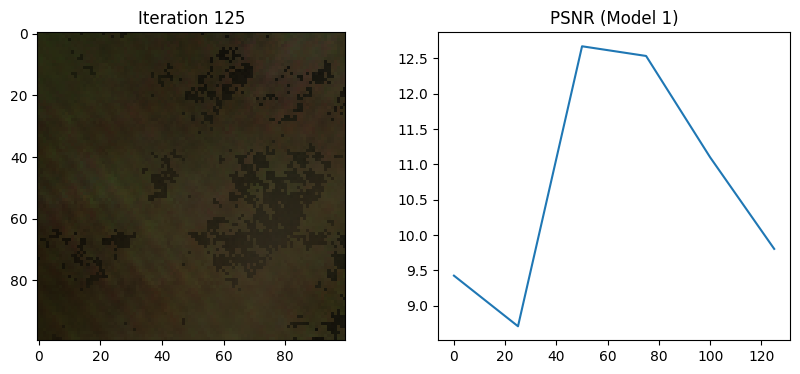

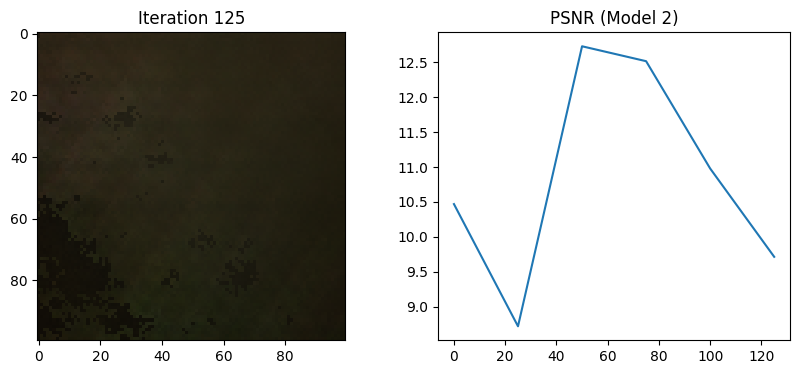

Loss: 0.044181082397699356
Loss: 0.04129061475396156


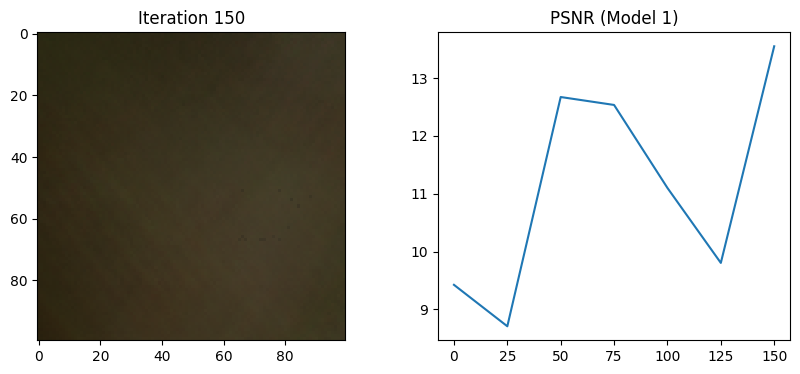

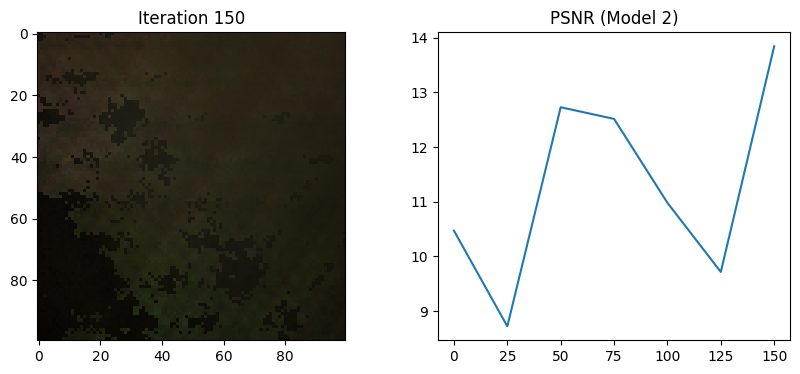

Loss: 0.10882037878036499
Loss: 0.1163848340511322


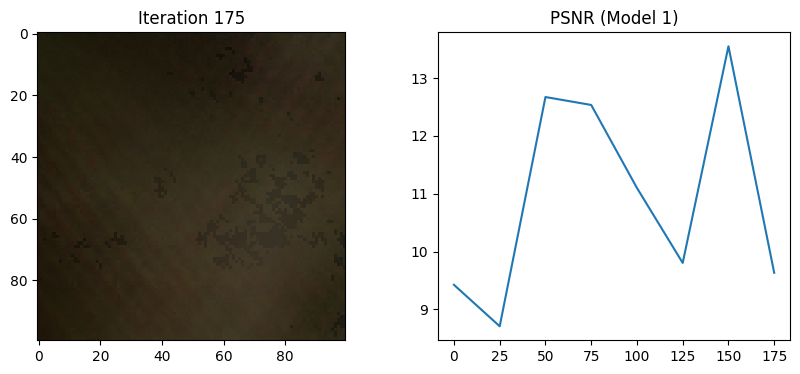

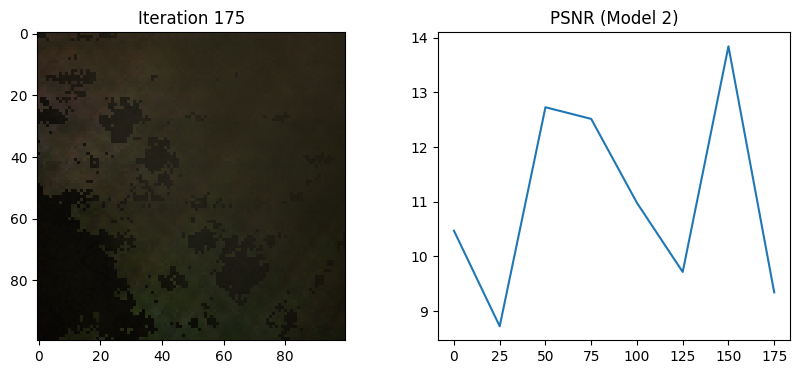

Loss: 0.05578799545764923
Loss: 0.05654482543468475


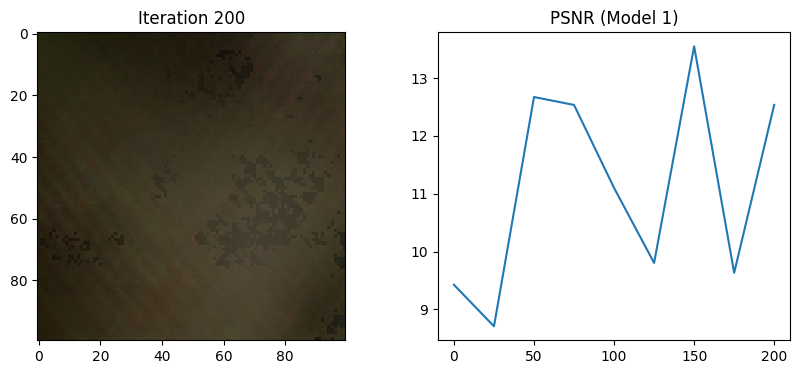

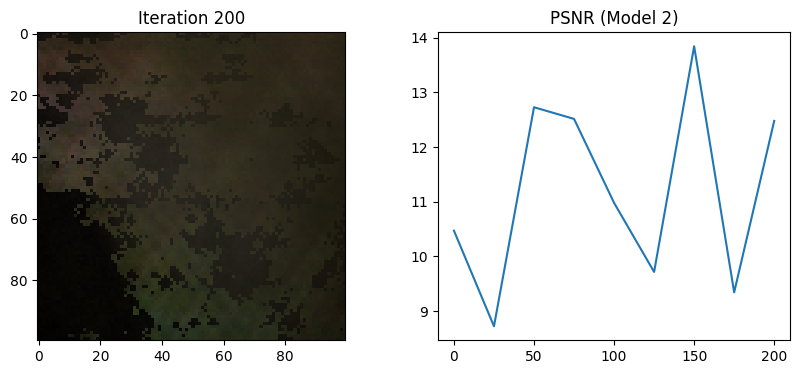

Loss: 0.1040300503373146
Loss: 0.11438386887311935


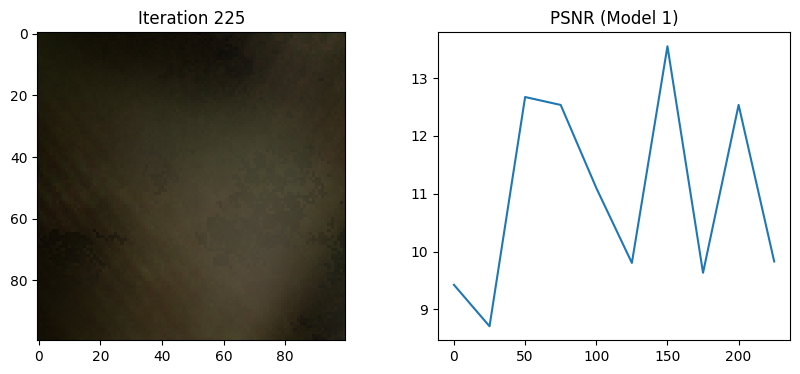

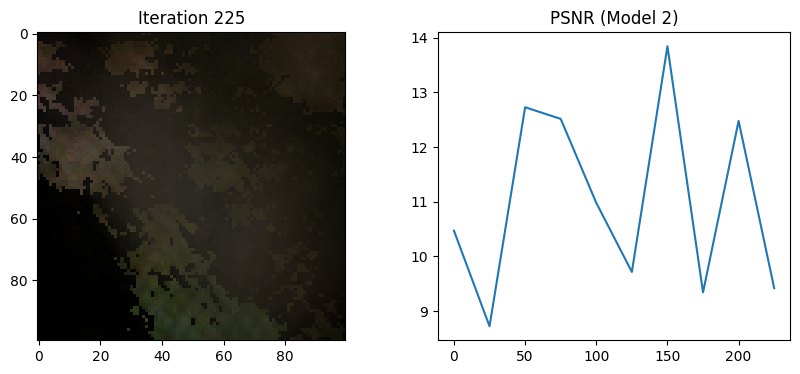

Loss: 0.0238264799118042
Loss: 0.019698530435562134


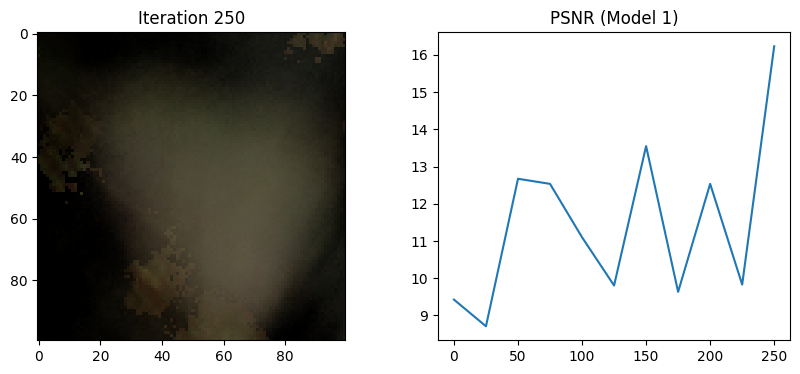

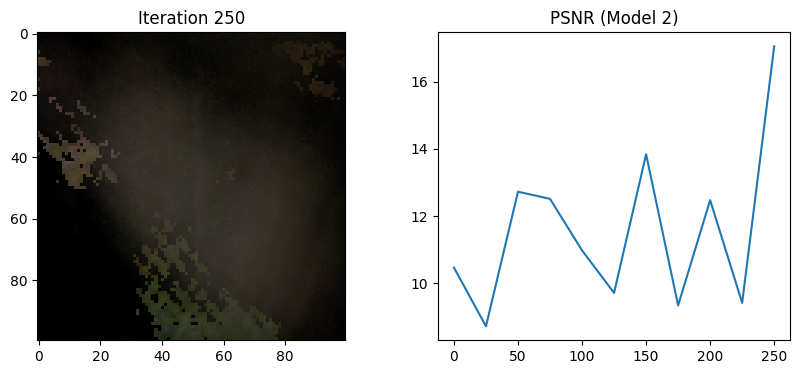

Loss: 0.0567549392580986
Loss: 0.06290143728256226


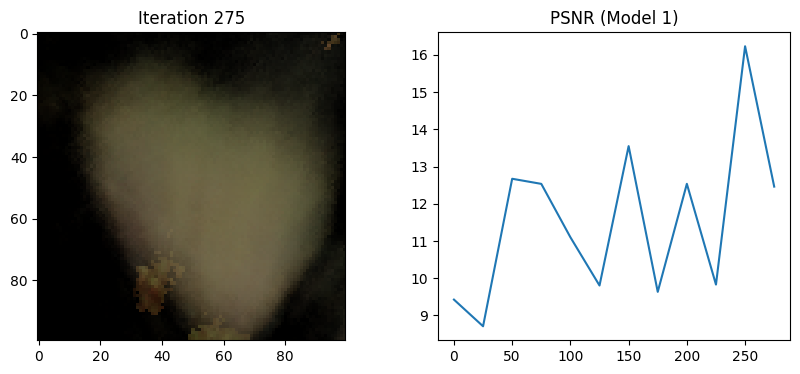

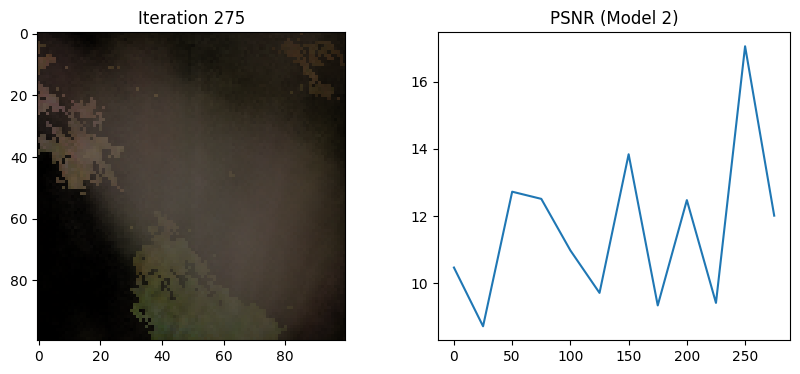

Loss: 0.06660424172878265
Loss: 0.07005663216114044


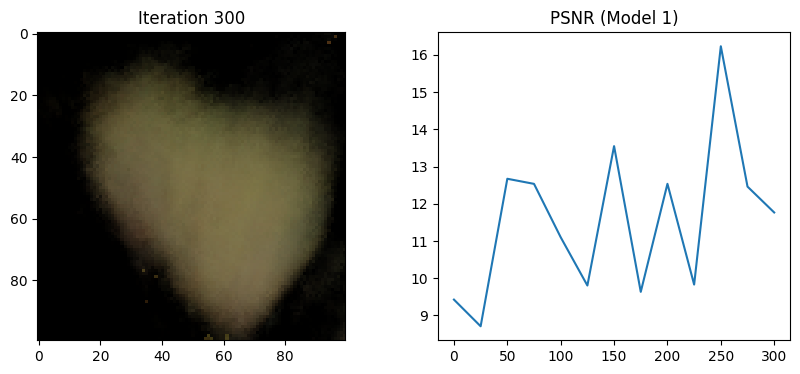

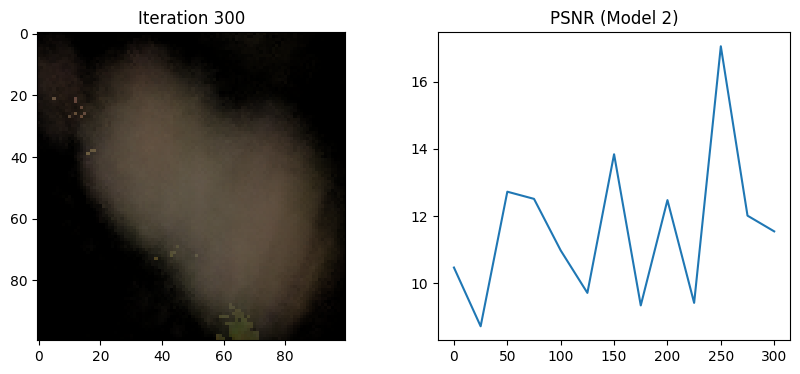

Loss: 0.04466961324214935
Loss: 0.026511535048484802


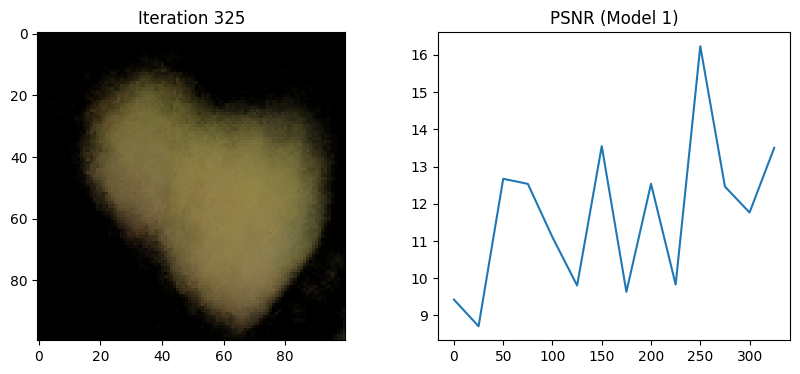

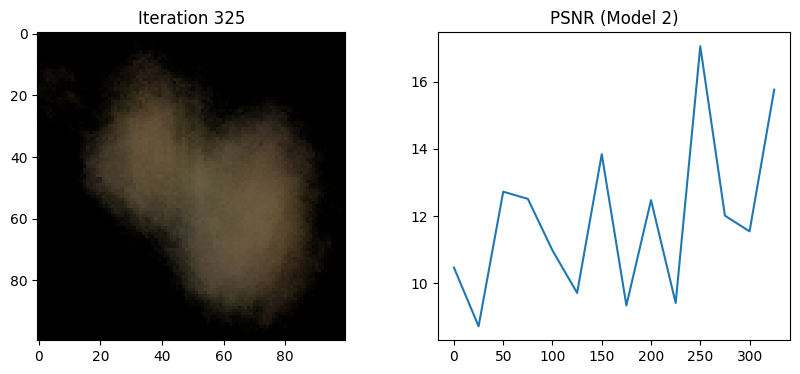

Loss: 0.06907065212726593
Loss: 0.0646325871348381


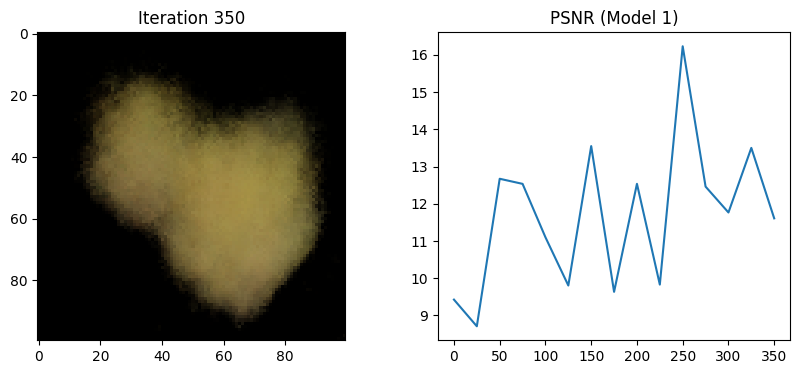

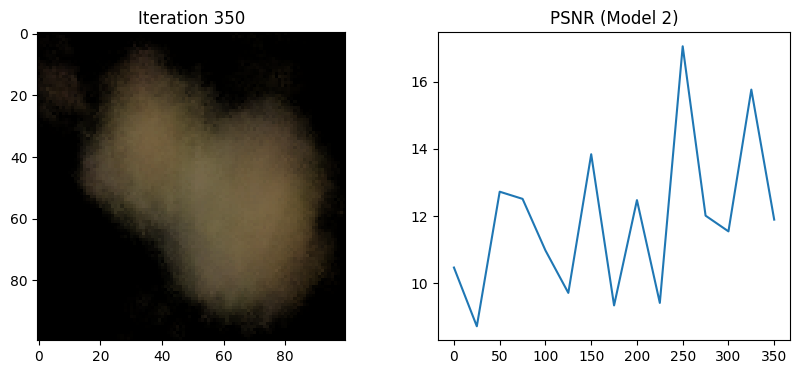

Loss: 0.08423727005720139
Loss: 0.07221426069736481


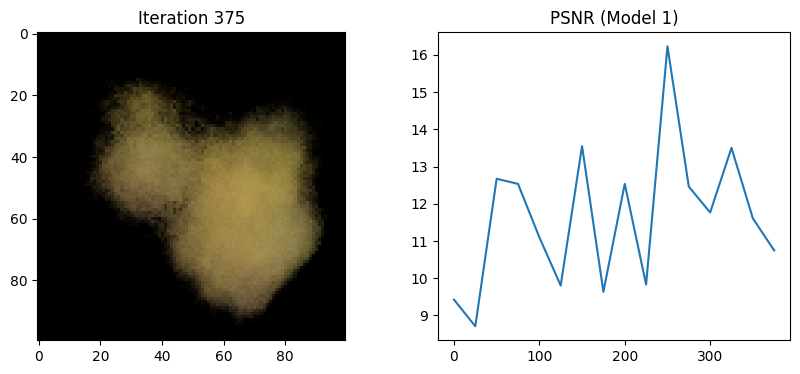

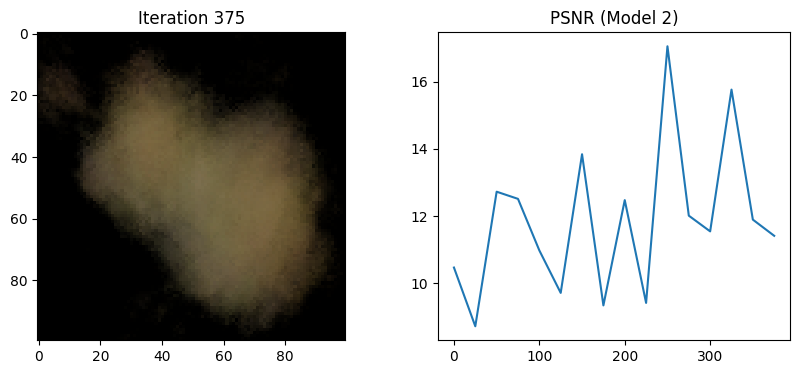

Loss: 0.04475352540612221
Loss: 0.0314878411591053


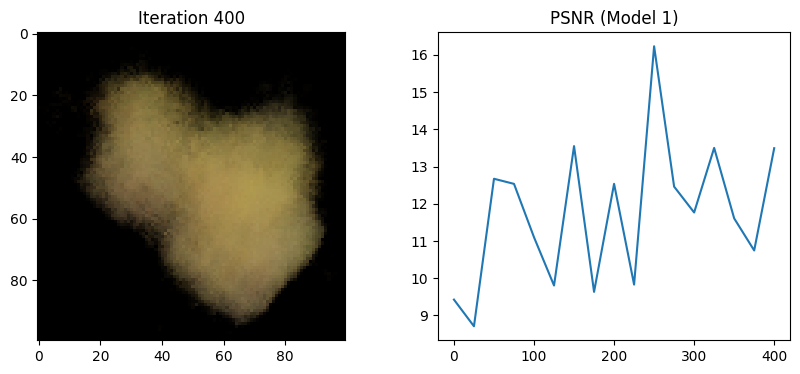

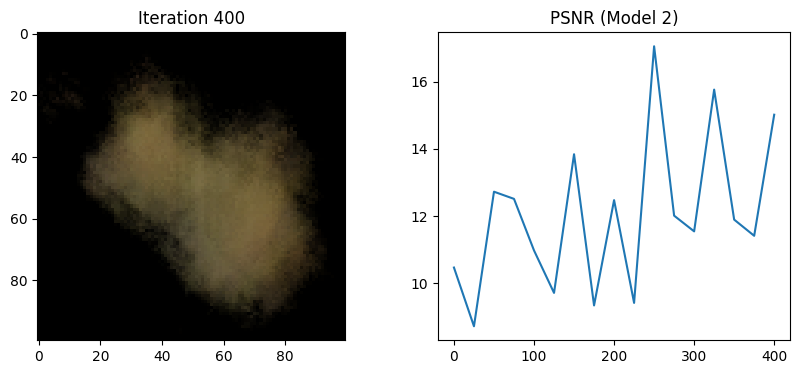

Loss: 0.05652227625250816
Loss: 0.047006942331790924


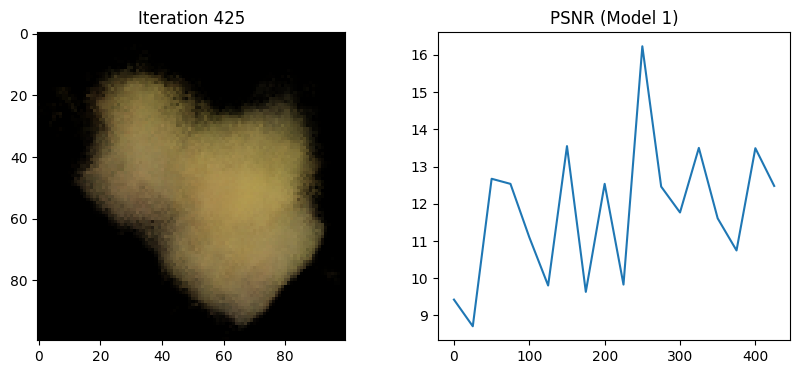

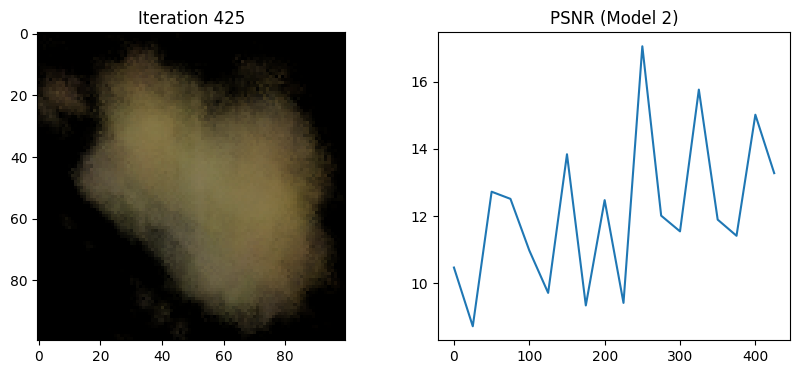

Loss: 0.05406329408288002
Loss: 0.05265558511018753


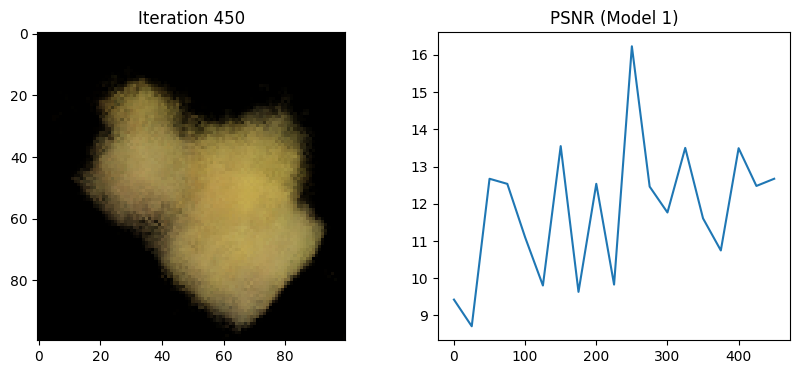

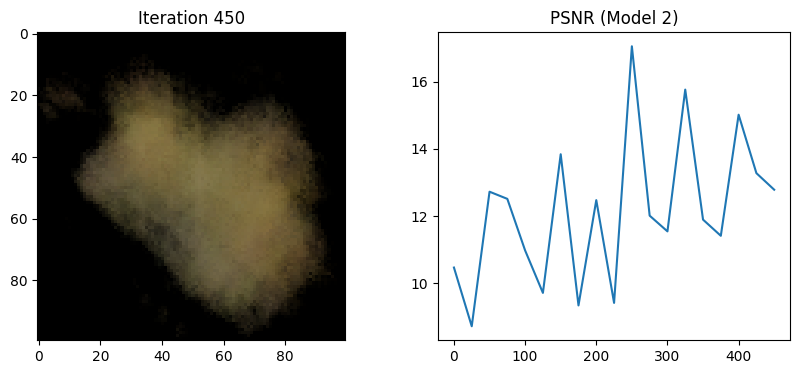

Loss: 0.0669601708650589
Loss: 0.05347014218568802


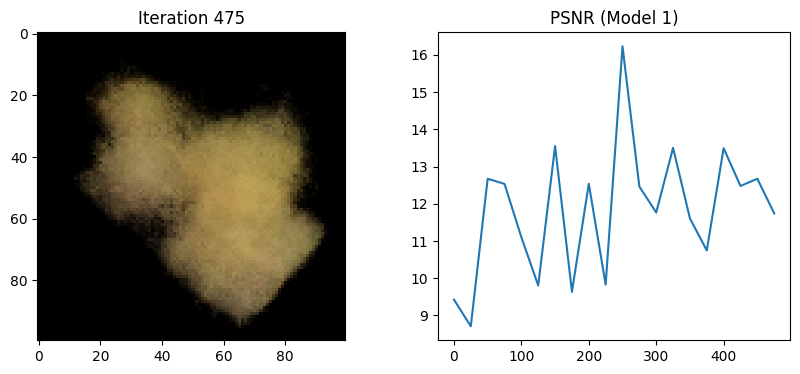

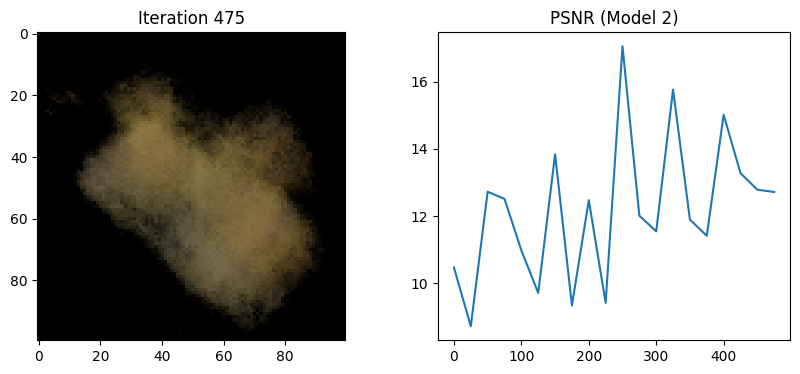

Loss: 0.03424365445971489
Loss: 0.030648071318864822


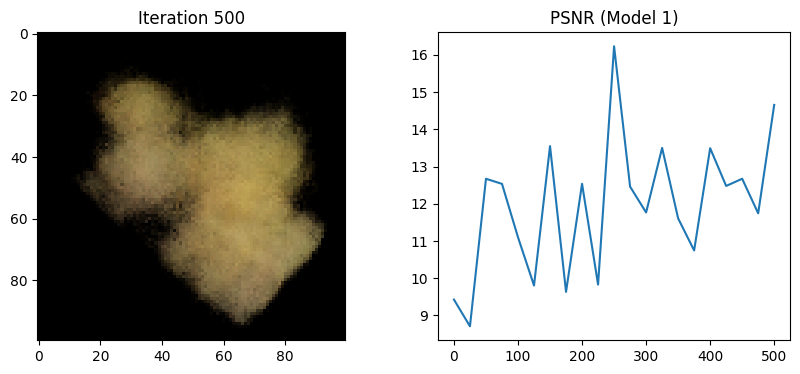

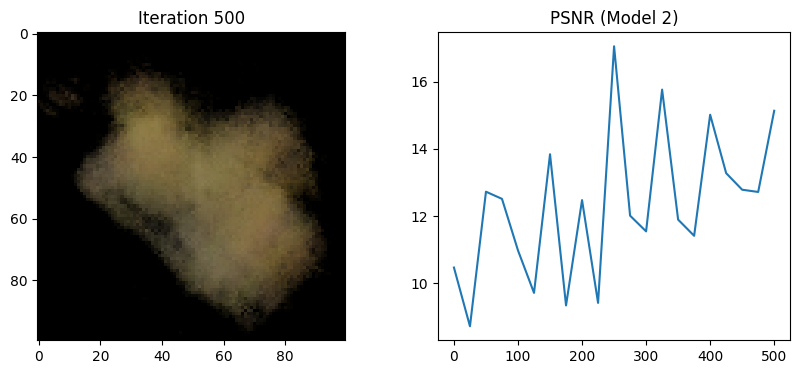

Loss: 0.07405965030193329
Loss: 0.04080090671777725


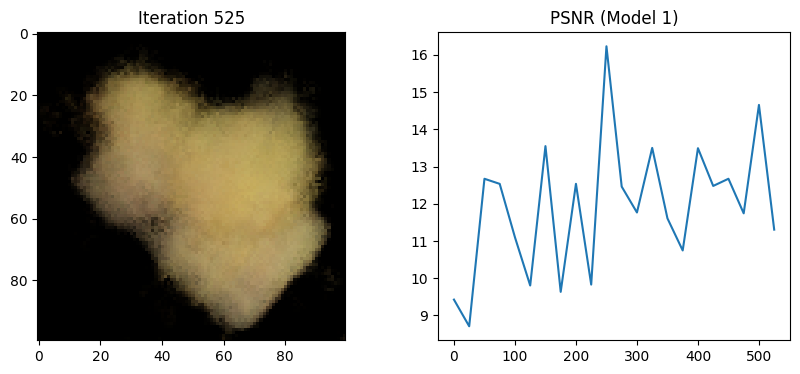

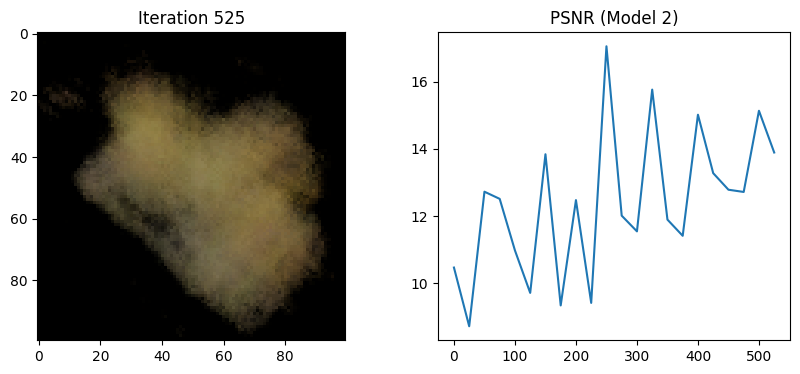

Loss: 0.045724935829639435
Loss: 0.04363979771733284


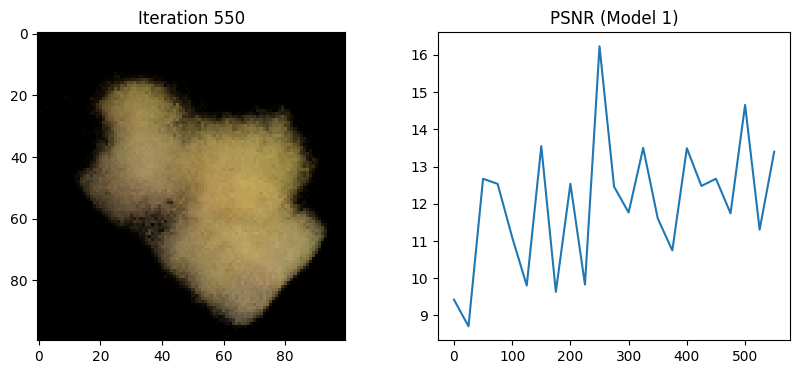

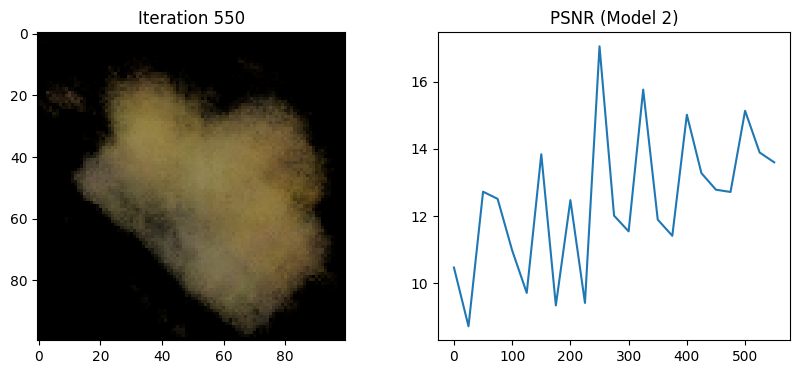

Loss: 0.0537743903696537
Loss: 0.04504380002617836


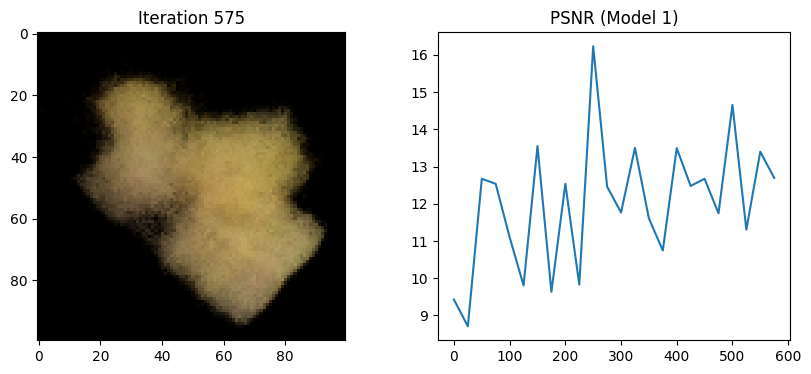

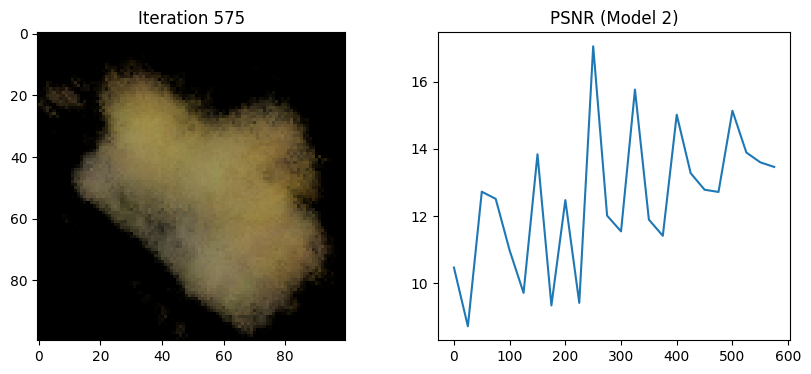

Loss: 0.08349476009607315
Loss: 0.07268719375133514


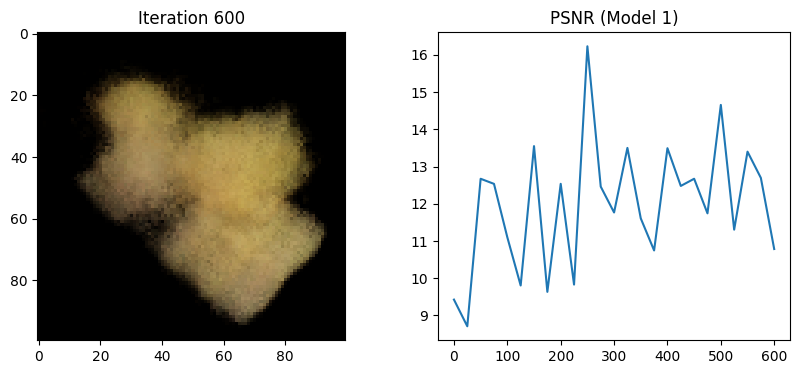

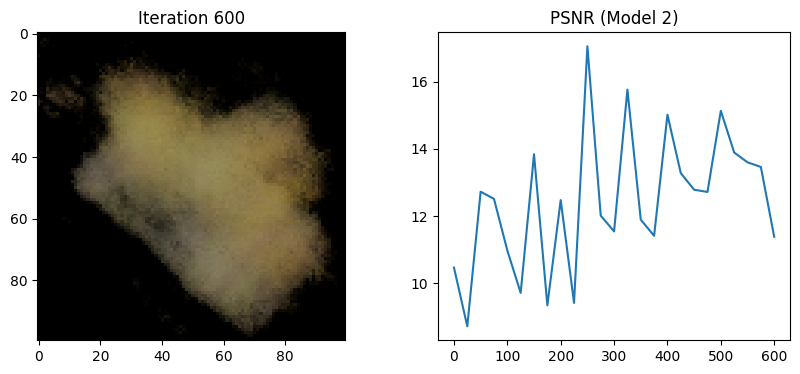

Loss: 0.05929775536060333
Loss: 0.043716613203287125


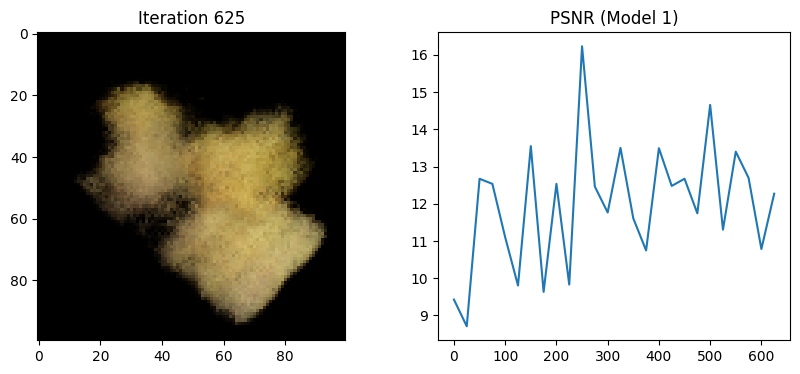

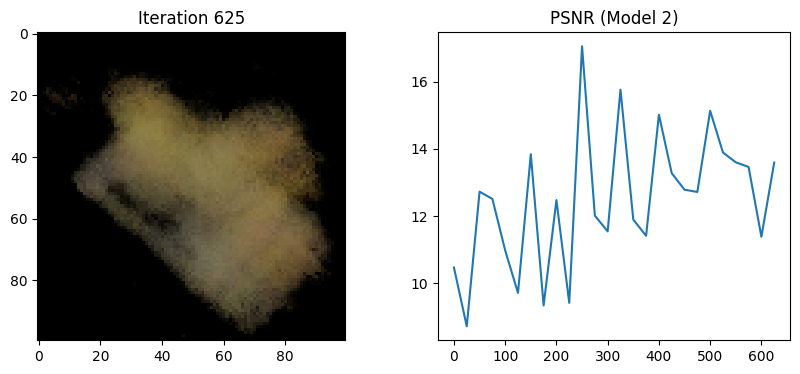

Loss: 0.07037489861249924
Loss: 0.03415277600288391


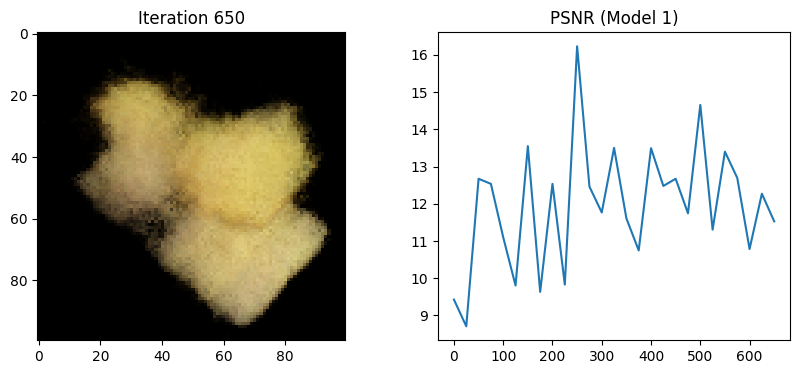

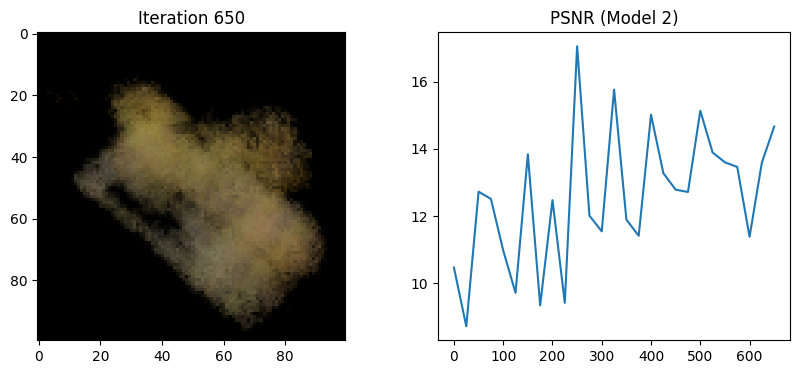

Loss: 0.08207736164331436
Loss: 0.049936890602111816


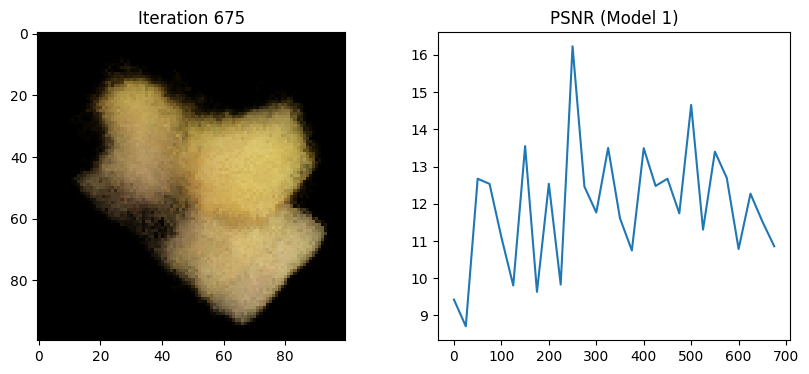

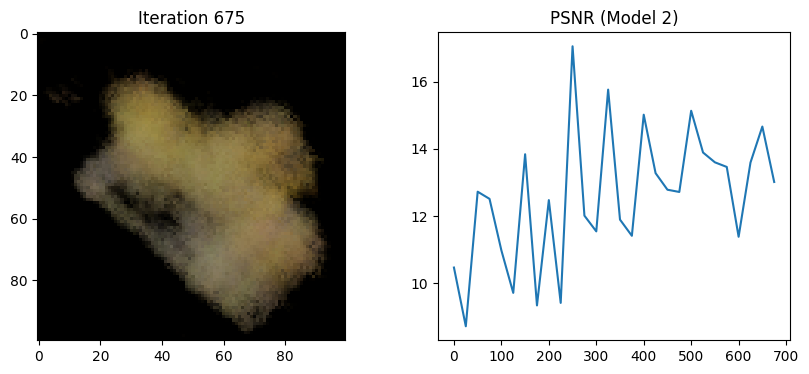

Loss: 0.07913198322057724
Loss: 0.0530523918569088


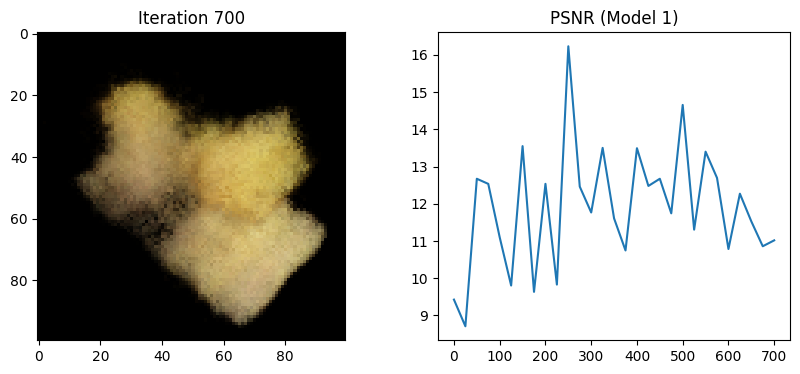

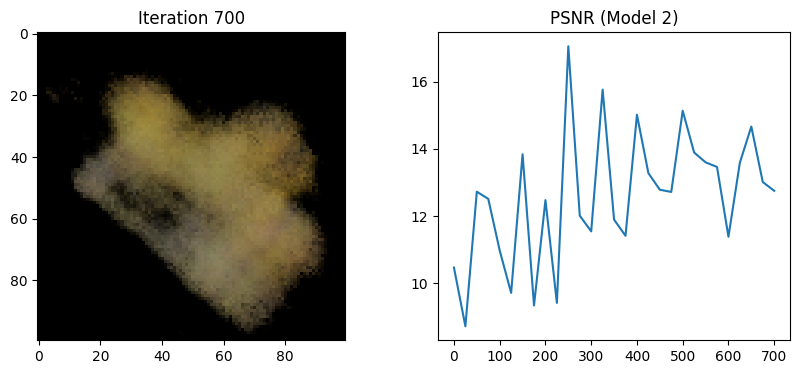

Loss: 0.12533974647521973
Loss: 0.11009033024311066


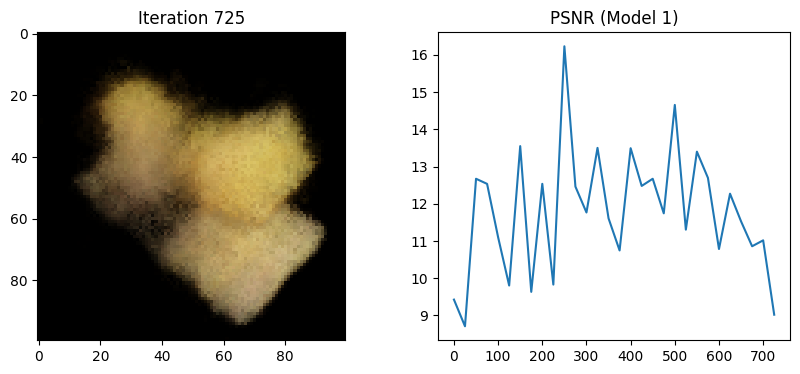

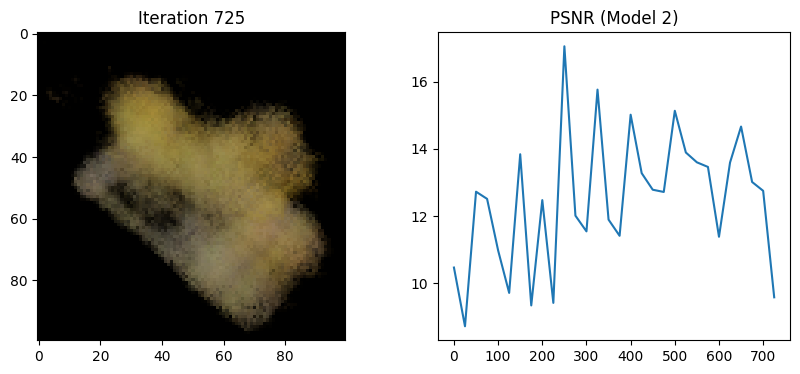

Loss: 0.04344435781240463
Loss: 0.03383918106555939


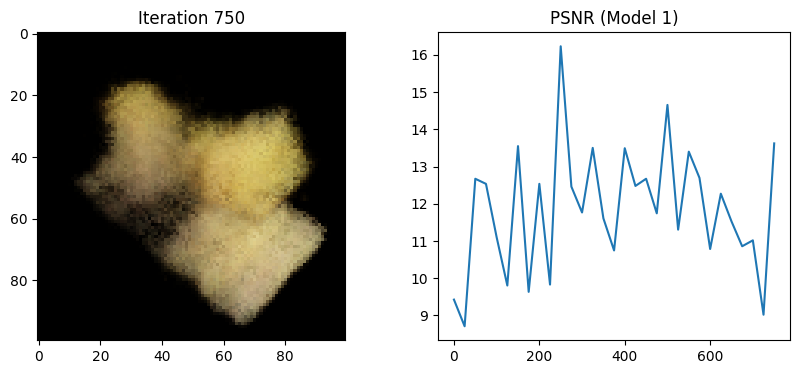

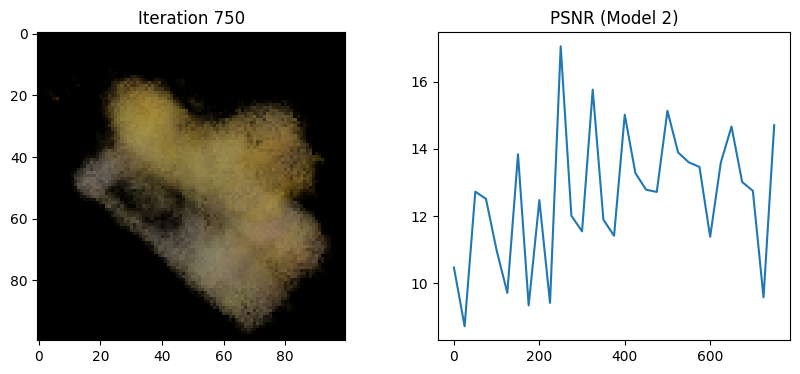

Loss: 0.09602867811918259
Loss: 0.041366539895534515


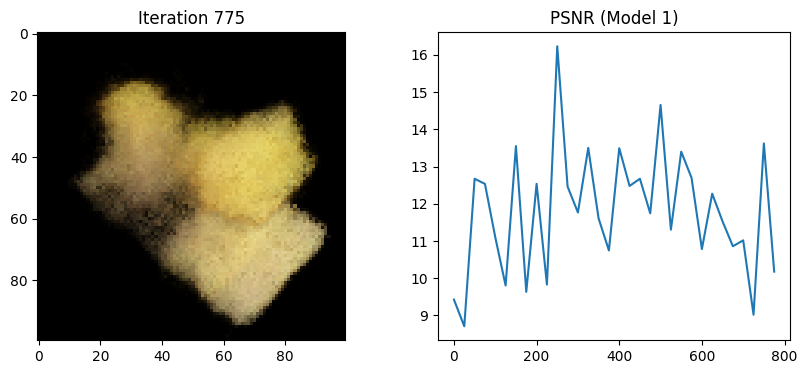

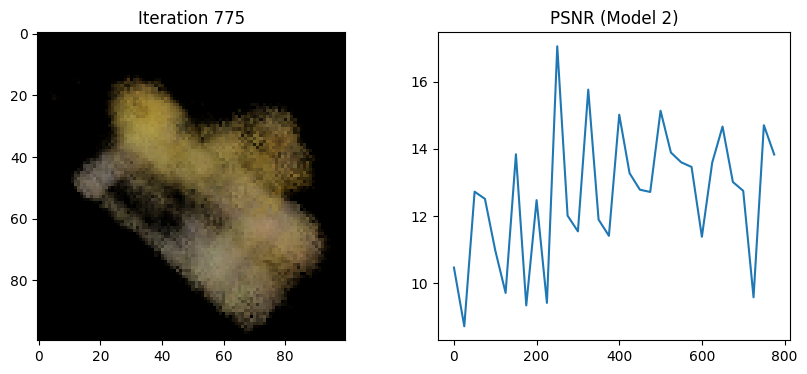

Loss: 0.0778924748301506
Loss: 0.06339410692453384


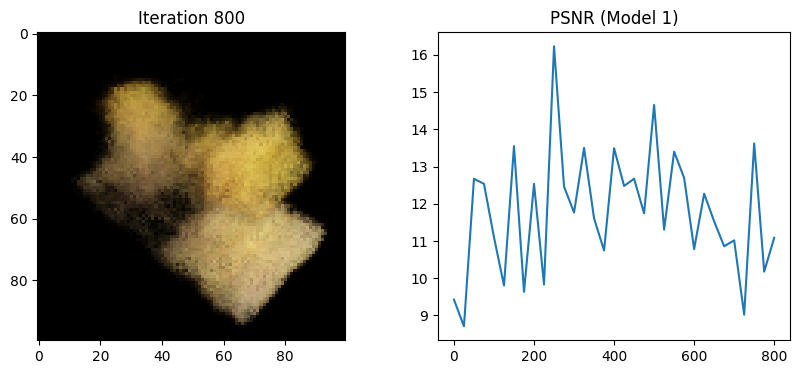

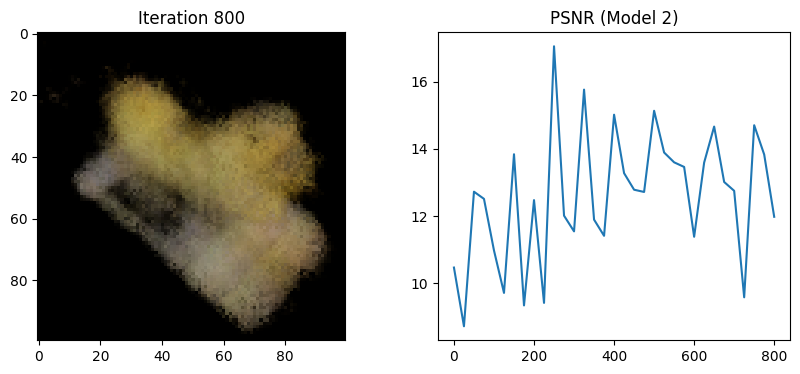

Loss: 0.05328793078660965
Loss: 0.04696716368198395


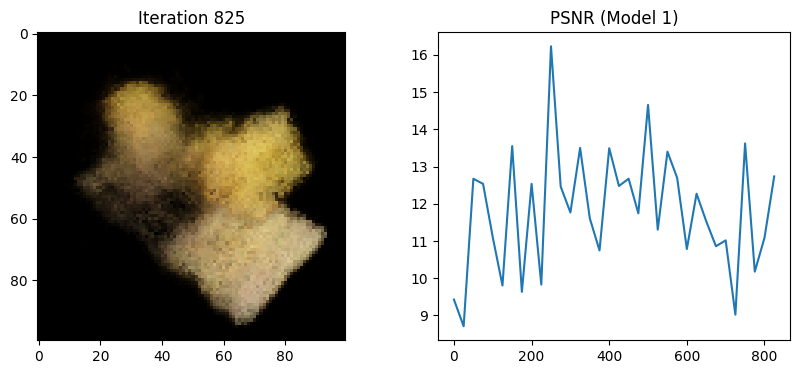

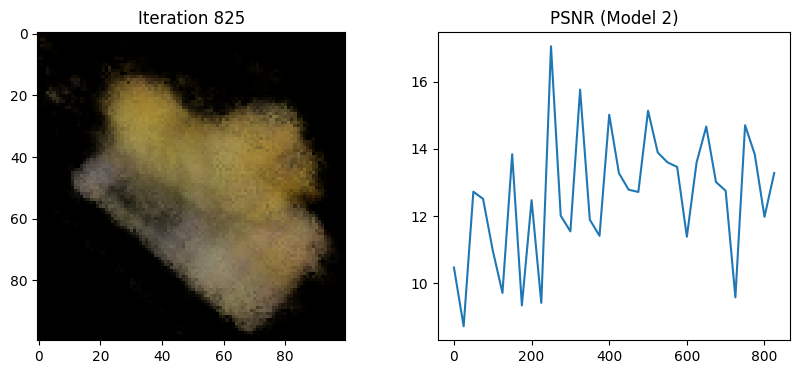

Loss: 0.06979852169752121
Loss: 0.05169597268104553


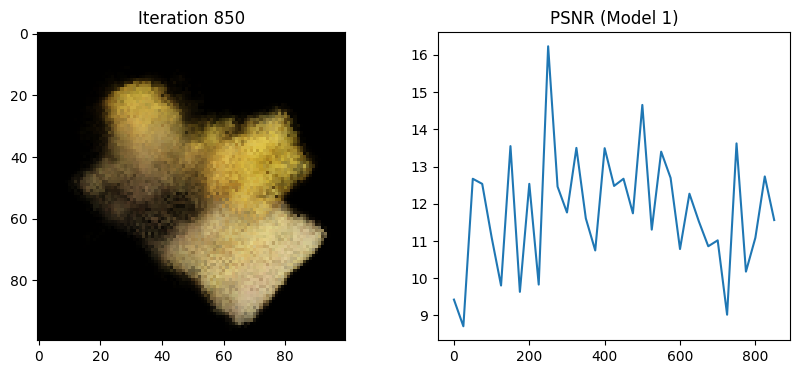

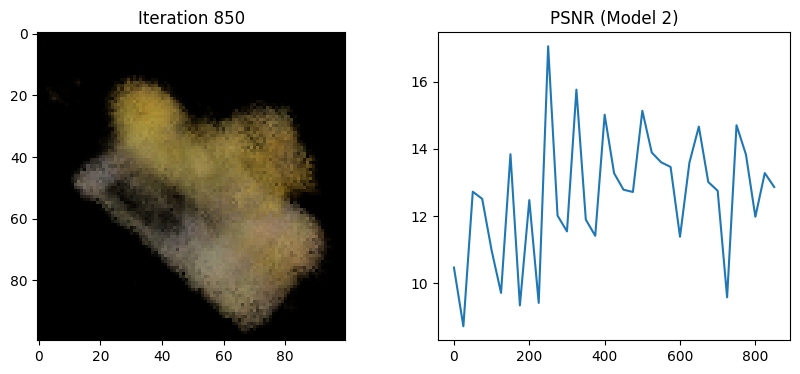

Loss: 0.07635044306516647
Loss: 0.043719399720430374


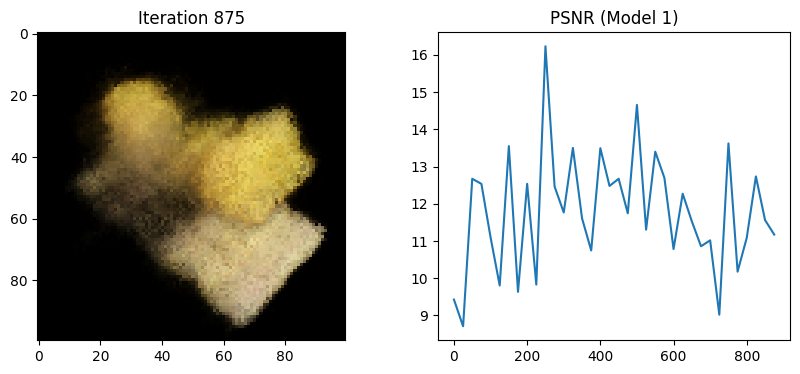

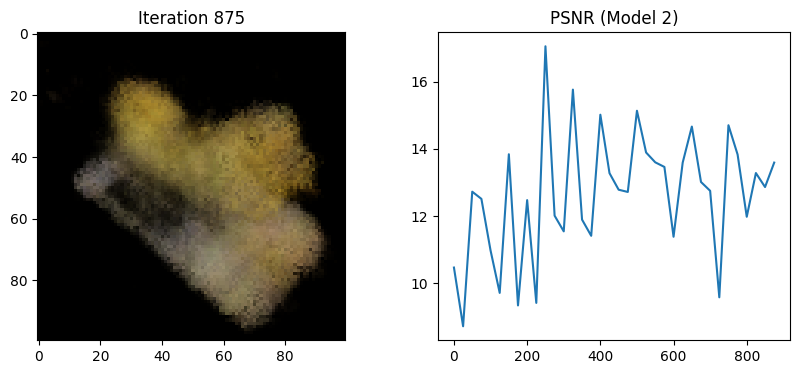

Loss: 0.05706994980573654
Loss: 0.04553968459367752


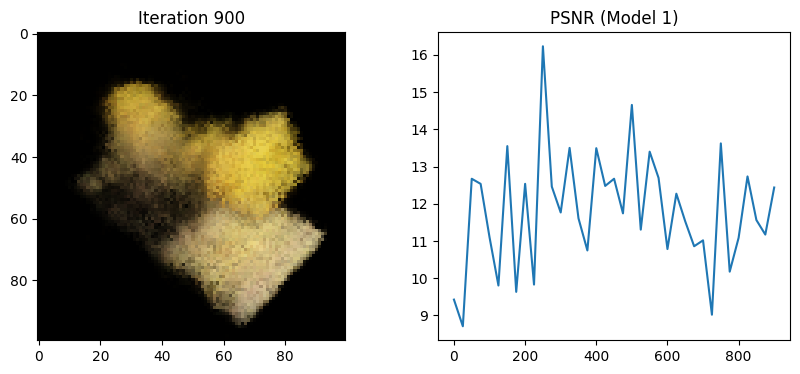

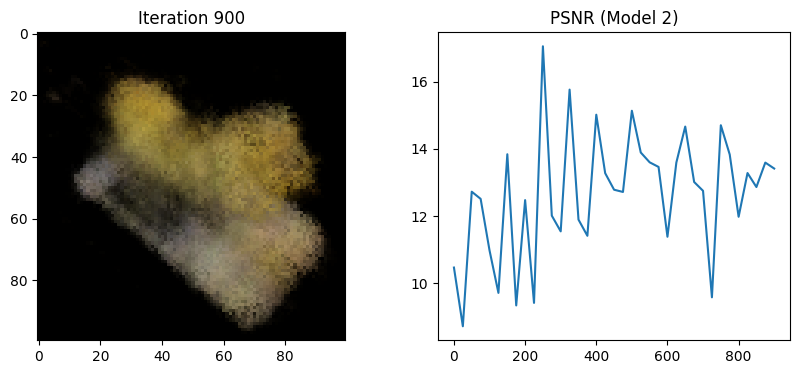

Loss: 0.09158501774072647
Loss: 0.07250089943408966


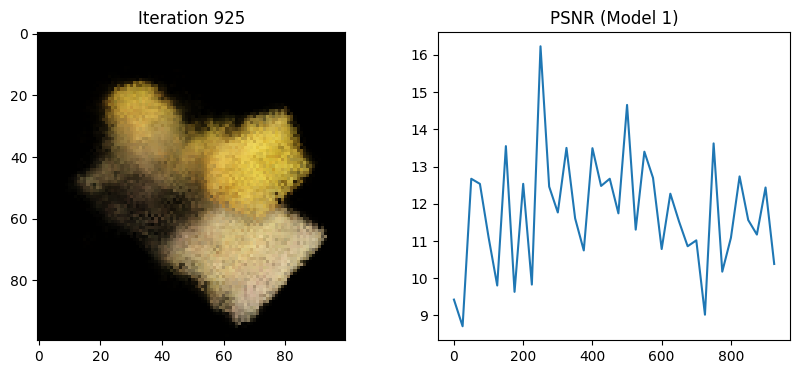

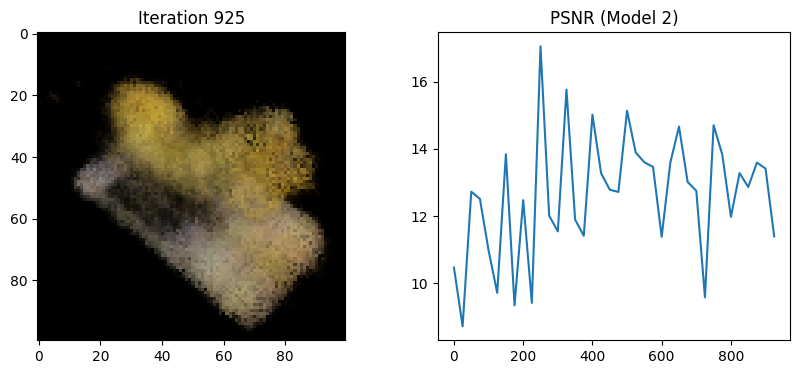

Loss: 0.10332100093364716
Loss: 0.03749191015958786


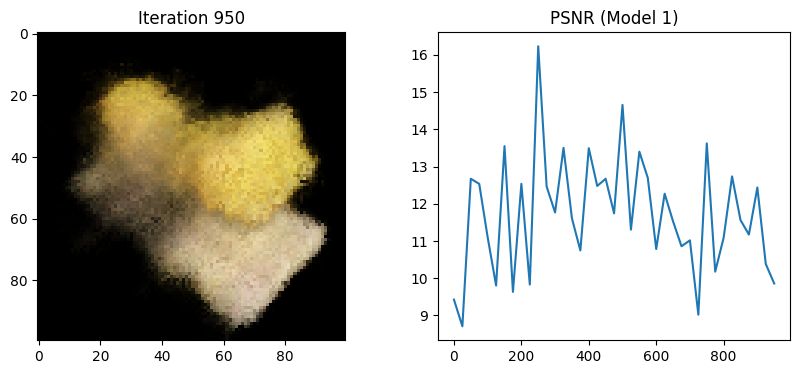

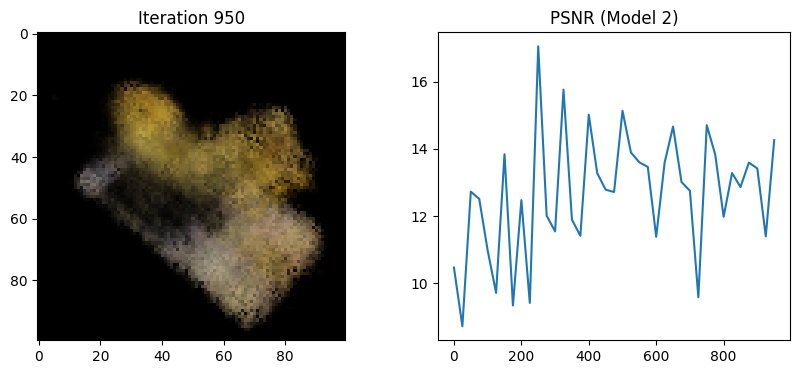

Loss: 0.07473992556333542
Loss: 0.06001370772719383


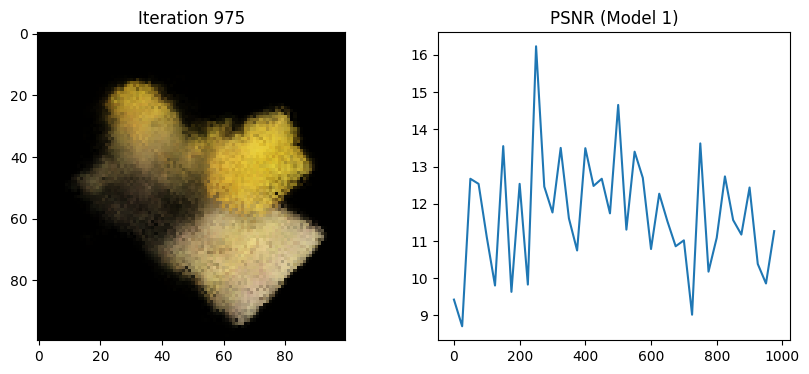

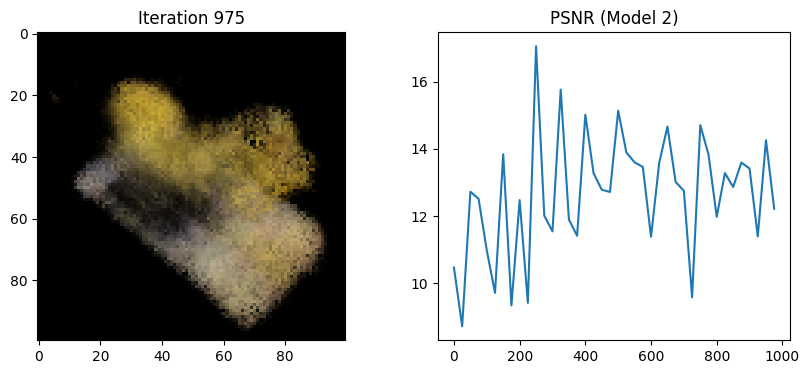

Done!


In [ ]:

"""
Model 1
"""
model_front = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model_front.to(device)

"""
Optimizer
"""
optimizer1 = torch.optim.Adam(model_front.parameters(), lr=lr)

"""
Model 2
"""
model_rear = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model_rear.to(device)
optimizer2 = torch.optim.Adam(model_rear.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs1 = []
iternums = []
psnrs2 = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  if(target_tform_cam2world[0,0] > 0.1):
    rgb_predicted1 = run_one_iter_of_tinynerf_front(height, width, focal_length,
                                            target_tform_cam2world, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted1, target_img)
    loss.backward()
    optimizer1.step()
    optimizer1.zero_grad()


  elif(target_tform_cam2world[0,0] < -0.1):
    rgb_predicted2 = run_one_iter_of_tinynerf_rear(height, width, focal_length,
                                            target_tform_cam2world, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted2, target_img)
    loss.backward()
    optimizer2.step()
    optimizer2.zero_grad()

# Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    with torch.no_grad():
      rgb_predicted1 = run_one_iter_of_tinynerf_front(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted1, target_img)
      print("Loss:", loss.item())
      psnr1 = -10. * torch.log10(loss)

      psnrs1.append(psnr1.item())
      iternums.append(i)
      plt.figure(figsize=(10, 4))
      plt.subplot(121)
      plt.imshow(rgb_predicted1.detach().cpu().numpy())
      plt.title(f"Iteration {i}")
      plt.subplot(122)
      plt.plot(iternums, psnrs1)
      plt.title("PSNR (Model 1)")

      rgb_predicted2 = run_one_iter_of_tinynerf_rear(height, width, focal_length,
                                              testpose, near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, get_minibatches)
      loss = torch.nn.functional.mse_loss(rgb_predicted2, target_img)
      print("Loss:", loss.item())
      psnr2 = -10. * torch.log10(loss)

      psnrs2.append(psnr2.item())
      plt.figure(figsize=(10, 4))
      plt.subplot(121)
      plt.imshow(rgb_predicted2.detach().cpu().numpy())
      plt.title(f"Iteration {i}")
      plt.subplot(122)
      plt.plot(iternums, psnrs2)
      plt.title("PSNR (Model 2)")
      plt.show()

print('Done!')

In [ ]:

import scipy

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#train aug loader에는 positional encoding이 모두 끝난 후에 39의 size를 가지는 input value들이다.
#-> 한개의 타겟이미지에 여러 batch가 있음 batch를 학습시키는 epoch를 반복하는 gamma의 도입이 필요해 보임, targetimage수 만큼 batches를 반복해서 가져오고 attach해야할듯
#확인해보니, batches = get_minibatches_function(encoded_points, chunksize=chunksize) 여기서 한 batches가 여기서 사용한 train_aug_loader여야한다.
def get_batches_from(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
    ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

  # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
    encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches_function(encoded_points, chunksize=chunksize)
    return batches

def run_corr_matrix(net0, net1):
    n = len(train_aug_loader)
    with torch.no_grad():
        #net0.eval()
        #net1.eval()
        for i, TinyNerfInput_39size in enumerate(tqdm(train_aug_loader)):

            #img_t = images.float().cuda()

            out0 = net0(TinyNerfInput_39size.float().cuda()).double()

            #out0 = out0.permute(0, 2, 3, 1).reshape(-1, out0.shape[1])
            out0 = out0.permute(0, 1).reshape(-1, out0.shape[1])

            out1 = net1(TinyNerfInput_39size.float().cuda()).double()
            #out1 = out1.permute(0, 2, 3, 1).reshape(-1, out1.shape[1])
            out1 = out1.permute(0, 1).reshape(-1, out1.shape[1])

            # save batchwise first+second moments and outer product
            mean0_b = out0.mean(dim=0)
            mean1_b = out1.mean(dim=0)
            sqmean0_b = out0.square().mean(dim=0)
            sqmean1_b = out1.square().mean(dim=0)
            outer_b = (out0.T @ out1) / out0.shape[0]
            if i == 0:
                mean0 = torch.zeros_like(mean0_b)
                mean1 = torch.zeros_like(mean1_b)
                sqmean0 = torch.zeros_like(sqmean0_b)
                sqmean1 = torch.zeros_like(sqmean1_b)
                outer = torch.zeros_like(outer_b)
            mean0 += mean0_b / n
            mean1 += mean1_b / n
            sqmean0 += sqmean0_b / n
            sqmean1 += sqmean1_b / n
            outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    std0 = (sqmean0 - mean0**2).sqrt()
    std1 = (sqmean1 - mean1**2).sqrt()
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [ ]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map


def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

In [ ]:
def permute_output(perm_map, layer):
    pre_weights = [layer.weight,
                   layer.bias]
    for w in pre_weights:
        w.data = w[perm_map]

def permute_input(perm_map, layer):
    w = layer.weight
    w.data = w[:, perm_map]

In [ ]:
#model 0에다가 model1 fit 시킬예정임

def save_model(model, i):
    sd = model.state_dict()
    torch.save(model.state_dict(), '%s.pt' % i)

save_model(model_front, 'model_front')
save_model(model_rear, 'model_rear')


In [ ]:
model_front = VeryTinyNerfModel().cuda()
model_front.get_features()
model_front.load_state_dict(torch.load('model_front.pt'), strict=False)
model_rear = VeryTinyNerfModel().cuda()
model_rear.get_features()
model_rear.load_state_dict(torch.load('model_rear.pt'), strict=False)

_IncompatibleKeys(missing_keys=['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.4.weight', 'features.4.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias'], unexpected_keys=[])

In [ ]:
model_front.get_features()
model_rear.get_features()


Sequential(
  (0): Linear(in_features=39, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Linear(in_features=128, out_features=128, bias=True)
  (15): ReLU()
  (16): Linear(in_features=128, out_features=128, bias=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=4, bias=True)
)

In [ ]:
from tqdm import tqdm
def subnet(model, n_layers):
    return model.features[:n_layers]

feats1 = model_rear.features
n = len(feats1)
epoch = 100  #100이하의 값으로 설정되어야 할듯 함, 그리고 겹치는데이터가 아니면 효율이 더좋을것 같으나,
            #원래 목적 자체가 모델을 다시 학습하는것을 막자가 주 목적이므로, 상당히 낮은 값으로 책정되야함
for e in range(epoch):
    target_img_idx = np.random.randint(images.shape[0])
    target_img = images[target_img_idx].to(device)
    target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

    train_aug_loader = get_batches_from(height, width, focal_length,
                    target_tform_cam2world, near_thresh,
                    far_thresh, depth_samples_per_ray,
                    encode, get_minibatches)

    for i in range(n-1):
        #만약 안에 linear instance가 없다면 당연히 건너뛰기
        if not isinstance(feats1[i], torch.nn.Linear):
            continue
        if not isinstance(feats1[i+1], torch.nn.BatchNorm1d):
          # permute the outputs of the current linear layer
          assert isinstance(feats1[i+1], torch.nn.ReLU)
          perm_map = get_layer_perm(subnet(model_front, i+2), subnet(model_rear, i+2))
          permute_output(perm_map, feats1[i])

          # look for the next conv layer, whose inputs should be permuted the same way
          #중요한건 아래부분 NeRF의 경우에는 모든 layer가 단순한 fcn구조로 되어있다. 그래서 위에 부분을 nn.conv instance로 확인하는 것이 아닌 nn.linear 인지 확인할예정
          next_layer = None
          for j in range(i+1, n):
              if isinstance(feats1[j], torch.nn.Linear):
                  next_layer = feats1[j]
                  break
          if next_layer == None:
              break
          permute_input(perm_map, next_layer)
        else: #i+1 = Batchnorm
          # permute the outputs of the current linear layer
          assert isinstance(feats1[i+2], torch.nn.ReLU)
          assert isinstance(feats1[i+1], torch.nn.BatchNorm1d)
          perm_map = get_layer_perm(subnet(model_front, i+3), subnet(model_rear, i+3))
          permute_output(perm_map, feats1[i])

          # look for the next conv layer, whose inputs should be permuted the same way
          #중요한건 아래부분 NeRF의 경우에는 모든 layer가 단순한 fcn구조로 되어있다. 그래서 위에 부분을 nn.conv instance로 확인하는 것이 아닌 nn.linear 인지 확인할예정
          next_layer = None
          for j in range(i+2, n):
              if isinstance(feats1[j], torch.nn.Linear):
                  next_layer = feats1[j]
                  break
              #elif isinstance(feats1[j], torch.nn.BatchNorm1d):
               #   next_layer = feats1[j]
          if next_layer == None:
              break
          permute_input(perm_map, next_layer)

100%|██████████| 20/20 [00:00<00:00, 702.45it/s]


In [ ]:
save_model(model_rear, 'model_rear_matched')

def mix_weights(net, alpha, key0, key1):
    sd0 = torch.load('./%s.pt' % key0)
    sd1 = torch.load('./%s.pt' % key1)

    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in net.state_dict().keys()}

    net.load_state_dict(sd_alpha)

In [ ]:
k0 = 'model_front'
k1 = 'model_rear_matched'

model0 = VeryTinyNerfModel()
model1 = VeryTinyNerfModel()
model_merge = VeryTinyNerfModel()
model_merge_justpermute = VeryTinyNerfModel()

mix_weights(model_merge_justpermute, 0.5, k0, 'model_rear')
mix_weights(model0, 0.0, k0, k1)
mix_weights(model1, 1.0, k0, k1)

alpha = 0.5
mix_weights(model_merge, alpha, k0, k1)

model_merge.to(device)
model_merge_justpermute.to(device)

VeryTinyNerfModel(
  (block1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
  )
  (layer1): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
def run_one_iter_of_tinynerf_merge(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model_merge(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

Loss: 0.07774706929922104
PSNR: 11.093159675598145


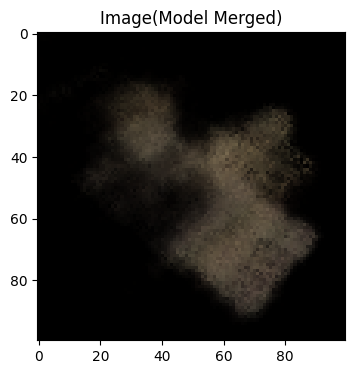

In [ ]:
rgb_predicted_merge = run_one_iter_of_tinynerf_merge(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
loss = torch.nn.functional.mse_loss(rgb_predicted_merge, target_img)
print("Loss:", loss.item())
psnr1 = -10. * torch.log10(loss)
print("PSNR:", psnr1.item())
plt.figure(figsize=(10, 4))
plt.imshow(rgb_predicted_merge.detach().cpu().numpy())
plt.title("Image(Model Merged)")
plt.show()

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (phi에 대한 회전)
rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (theta에 대한 회전)
rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 구면 좌표계에서의 포즈 설정 함수
def pose_spherical(theta, phi, radius):
    c2w = trans_t(torch.tensor(radius, dtype=torch.float32))
    c2w = torch.mm(rot_phi(torch.tensor(phi / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(rot_theta(torch.tensor(theta / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32), c2w)
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    img = run_one_iter_of_tinynerf_merge(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()
    #rgb = np.transpose(rgb, (1, 2, 0))
    img = np.clip(rgb,0,255)*2

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    with torch.no_grad():
      img = run_one_iter_of_tinynerf_merge(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()*3
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:07<00:00, 15.40it/s]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# **NAIVE PERMUTATION**

In [ ]:
def run_one_iter_of_tinynerf_merge_justpermute(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model_merge_justpermute(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

Loss: 0.09631159156560898
PSNR: 10.163213729858398


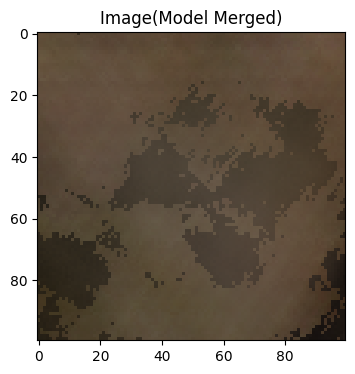

In [ ]:
rgb_predicted_merge = run_one_iter_of_tinynerf_merge_justpermute(height, width, focal_length,
                                            testpose, near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
loss = torch.nn.functional.mse_loss(rgb_predicted_merge, target_img)
print("Loss:", loss.item())
psnr1 = -10. * torch.log10(loss)
print("PSNR:", psnr1.item())
plt.figure(figsize=(10, 4))
plt.imshow(rgb_predicted_merge.detach().cpu().numpy())
plt.title("Image(Model Merged)")
plt.show()

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (phi에 대한 회전)
rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (theta에 대한 회전)
rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 구면 좌표계에서의 포즈 설정 함수
def pose_spherical(theta, phi, radius):
    c2w = trans_t(torch.tensor(radius, dtype=torch.float32))
    c2w = torch.mm(rot_phi(torch.tensor(phi / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(rot_theta(torch.tensor(theta / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32), c2w)
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    img = run_one_iter_of_tinynerf_merge_justpermute(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()
    #rgb = np.transpose(rgb, (1, 2, 0))
    img = np.clip(rgb,0,255)*2

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    with torch.no_grad():
      img = run_one_iter_of_tinynerf_merge_justpermute(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()*3
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video_justpermute.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:07<00:00, 15.34it/s]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video_justpermute.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# **REPAIR 쓴거**

In [ ]:
class TrackLayer(torch.nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.bn = torch.nn.BatchNorm1d(layer.out_features)

    def get_stats(self):
        return (self.bn.running_mean, self.bn.running_var.sqrt())

    def forward(self, x):
        x1 = self.layer(x)
        self.bn(x1)
        return x1

class ResetLayer(torch.nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer
        self.bn = torch.nn.BatchNorm1d(layer.out_features)

    def set_stats(self, goal_mean, goal_std):
        self.bn.bias.data = goal_mean
        self.bn.weight.data = goal_std

    def forward(self, x):
        x1 = self.layer(x)
        return self.bn(x1)

# adds TrackLayers around every conv layer
def make_tracked_net(net):
    net1 = VeryTinyNerfModel()
    net1.get_features()
    net.get_features()
    net1.load_state_dict(net.state_dict(), strict = False)
    for i, layer in enumerate(net1.features):
      if i < 23:
        if isinstance(layer, torch.nn.Linear) and isinstance(net1.features[i+1], torch.nn.BatchNorm1d):
          if(i<=2):
            net1.layer1[i] = TrackLayer(layer)
          elif(i<=12):
            net1.block1[i-3] = TrackLayer(layer)
          elif(i<=22):
            net1.block2[i-13] = TrackLayer(layer)
    net1.get_features()
    return net1.cuda().eval()

# adds ResetLayers around every conv layer
def make_repaired_net(net):
    net1 = VeryTinyNerfModel()
    net1.get_features()
    net.get_features()
    net1.load_state_dict(net.state_dict(), strict = False)
    for i, layer in enumerate(net1.features):
      if i < 23:
        if isinstance(layer, torch.nn.Linear) and isinstance(net1.features[i+1], torch.nn.BatchNorm1d):
          if(i<=2):
            net1.layer1[i] = ResetLayer(layer)
          elif(i<=12):
            net1.block1[i-3] = ResetLayer(layer)
          elif(i<=22):
            net1.block2[i-13] = ResetLayer(layer)
    net1.get_features()
    return net1.cuda().eval()

In [ ]:
from torch.cuda.amp import autocast

In [ ]:
# reset all tracked BN stats against training data
def reset_bn_stats(model):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == torch.nn.BatchNorm1d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    model.train()
    with torch.no_grad(), autocast():
        for images in train_aug_loader:
            output = model(images.cuda())

In [ ]:
def fuse_linear_bn(linear, bn):
    fused_linear = torch.nn.Linear(linear.in_features,
                                 linear.out_features)

    # set weights
    w_linear = linear.weight.clone()
    bn_std = (bn.eps + bn.running_var).sqrt()
    gamma = bn.weight / bn_std
    fused_linear.weight.data = (w_linear * gamma.reshape(-1, 1))

    # set bias
    beta = bn.bias + gamma * (-bn.running_mean + linear.bias)
    fused_linear.bias.data = beta

    return fused_linear

def fuse_tracked_net(net):
    net1 = VeryTinyNerfModel()
    net1.get_features()
    net.get_features()
    for i, rlayer in enumerate(net.features):
        if isinstance(rlayer, ResetLayer):
            fused_linear = fuse_linear_bn(rlayer.layer, rlayer.bn)
            if(i<=2):
              net1.layer1[i].load_state_dict(fused_linear.state_dict(), strict = False)
            elif(i<=12):
              net1.block1[i-3].load_state_dict(fused_linear.state_dict(), strict = False)
            elif(i<=22):
              net1.block2[i-13].load_state_dict(fused_linear.state_dict(), strict = False)
        elif isinstance(rlayer, torch.nn.Linear):
            if(i<=2):
              net1.layer1[i].load_state_dict(net.layer1[i].state_dict(), strict = False)
            elif(i<=12):
              net1.block1[i-3].load_state_dict(net.block1[i-3].state_dict(), strict = False)
            elif(i<=22):
              net1.block2[i-13].load_state_dict(net.block2[i-13].state_dict(), strict = False)
            #net1.features[i].load_state_dict(fused_linear.state_dict(), strict = False)
    net1.layer2.load_state_dict(net.layer2.state_dict(), strict = False)
    return net1

In [ ]:
model_front = VeryTinyNerfModel().cuda()
model_front.load_state_dict(torch.load('model_front.pt'), strict=False)
model_front.get_features()
model_rear = VeryTinyNerfModel().cuda()
model_rear.load_state_dict(torch.load('model_rear.pt'), strict=False)
model_rear.get_features()

Sequential(
  (0): Linear(in_features=39, out_features=128, bias=True)
  (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=128, bias=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): ReLU()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Linear(in_features=128, out_features=128, bias=True)
  (14): ReLU()
  (15): Linear(in_features=128, out_features=128, bias=True)
  (16): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (17): ReLU()
  (18): Linear(in_features=128, out_features=128, bias=True)
  (19): ReLU()
  (20): Linear(in_features=128, out

In [ ]:

alpha = 0.5
model_merge.get_features()
    #print('(α=0): %.1f%% \t\t<-- Model A' % (100*evaluate(model0)))
    #print('(α=1): %.1f%% \t\t<-- Model B' % (100*evaluate(model1)))
    #print('(α=0.5): %.1f%% \t\t<-- Merged model' % (100*evaluate(model_a)))

    ## Calculate all neuronal statistics in the endpoint networks
wrap0 = make_tracked_net(model_rear)
wrap1 = make_tracked_net(model_front)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

wrap_a = make_repaired_net(model_merge)
    # Iterate through corresponding triples of (TrackLayer, TrackLayer, ResetLayer)
    # around conv layers in (model0, model1, model_a).
for track0, track1, reset_a in zip(wrap0.modules(), wrap1.modules(), wrap_a.modules()):
  if not isinstance(track0, TrackLayer):
    continue
  assert (isinstance(track0, TrackLayer)
            and isinstance(track1, TrackLayer)
            and isinstance(reset_a, ResetLayer))

        # get neuronal statistics of original networks
  mu0, std0 = track0.get_stats()
  mu1, std1 = track1.get_stats()

        # set the goal neuronal statistics for the merged network
  goal_mean = (1 - alpha) * mu0 + alpha * mu1
  goal_std = (1 - alpha) * std0 + alpha * std1

  reset_a.set_stats(goal_mean, goal_std)

    # Estimate mean/vars such that when added BNs are set to eval mode,
    # neuronal stats will be goal_mean and goal_std.
reset_bn_stats(wrap_a)
    # fuse the rescaling+shift coefficients back into conv layers
model_repair = fuse_tracked_net(wrap_a).to(device)

In [ ]:
def run_one_iter_of_tinynerf_Repair(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model_repair(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets

trans_t = lambda t: torch.tensor([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, t],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (phi에 대한 회전)
rot_phi = lambda phi: torch.tensor([
    [1, 0, 0, 0],
    [0, torch.cos(phi), -torch.sin(phi), 0],
    [0, torch.sin(phi), torch.cos(phi), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 회전 함수 (theta에 대한 회전)
rot_theta = lambda th: torch.tensor([
    [torch.cos(th), 0, -torch.sin(th), 0],
    [0, 1, 0, 0],
    [torch.sin(th), 0, torch.cos(th), 0],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 구면 좌표계에서의 포즈 설정 함수
def pose_spherical(theta, phi, radius):
    c2w = trans_t(torch.tensor(radius, dtype=torch.float32))
    c2w = torch.mm(rot_phi(torch.tensor(phi / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(rot_theta(torch.tensor(theta / 180. * np.pi, dtype=torch.float32)), c2w)
    c2w = torch.mm(torch.tensor([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]], dtype=torch.float32), c2w)
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    img = run_one_iter_of_tinynerf_Repair(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()
    #rgb = np.transpose(rgb, (1, 2, 0))
    img = np.clip(rgb,0,255)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    with torch.no_grad():
      img = run_one_iter_of_tinynerf_Repair(height, width, focal_length,
                                            c2w.to(device), near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, get_minibatches)
    rgb = img.detach().cpu().numpy()*2.8
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video1.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:09<00:00, 13.18it/s]
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video1.mp4','rb').read()
data_url = "data:video1/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)